In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import inspect

# Reflect Tables into SQLAlchemy ORM

In [3]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflecting an existing database into a new model
Base = automap_base()
# reflecting the tables
Base.prepare(engine, reflect=True)

In [6]:
# Displaying classes
Base.classes.keys()

['measurement', 'station']

In [7]:
# Saving data bases to variables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Starting session from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
#Getting the last date in Measurment DB
max_date = session.query(func.max(Measurement.date)).first()
max_date

('2017-08-23')

In [10]:
# Calculating the date 1 year ago from the last data point in the database
begin_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
begin_date

datetime.date(2016, 8, 23)

In [11]:
# Querying the Base tables returns results in a list
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= begin_date).order_by(Measurement.date).all()
data

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [12]:
# Getting names and types of columns in "measurement" data set
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Getting names and types of columns in "station" data set
inspector = inspect(engine)
columns = inspector.get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Save the query results as a Pandas DataFrame and setting the index to the date column
precip_df = pd.DataFrame(data, columns=["Date", "Precipitation"])
precip_df["Date"] = pd.to_datetime(precip_df["Date"])
#Resettinng index to Date column
precip_df = precip_df.set_index("Date")
#Dropping all N/As
precip_df = precip_df.dropna(how = "any")
#Sorting by Date colummn - ascending
precip_df = precip_df.sort_values(by="Date", ascending=True)
precip_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.08


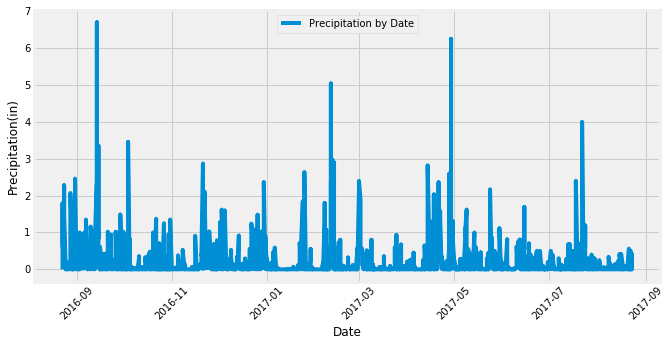

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,5))
plt.plot(precip_df, label="Precipitation by Date")
plt.xlabel("Date")
plt.ylabel("Precipitation(in)")
plt.xticks(rotation="45")
plt.legend(loc="upper center")
plt.savefig("Output/Precipitation_plot.png")
plt.show()

![precipitation](Images/precipitation.png)

In [16]:
#calcualting the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Query to count the number of stations in "Stations" data
session.query(func.count(Station.id)).all()

[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(Measurement.station,  func.min(Measurement.tobs), 
              func.max(Measurement.tobs), func.avg(Measurement.tobs)). filter(Measurement.station == "USC00519281").\
    group_by(Measurement.station).all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#Filtering data by date and by station
data_2 = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == "USC00519281").\
                    filter(func.strftime( Measurement.date) >= begin_date).all()
data_2

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [23]:
# Cleaning temp.data and setting index to date
temp_df = pd.DataFrame(data_2, columns=["Date", "Temperature"])
temp_df = temp_df.sort_values(by="Date", ascending=True)
temp_df.set_index("Date", inplace=True)
temp_df.head()

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


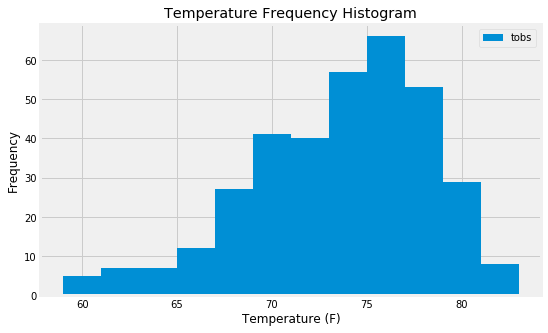

In [24]:
plt.figure(figsize=[8,5])
#Ploting the results as a histogram with 12 bins

plt.hist(x=temp_df["Temperature"], bins=12, label="tobs")
# Labeling figure
plt.grid
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Frequency Histogram")
plt.legend()
# Saving Plot
plt.savefig("Output/Temp Frequency Histogram");

plt.show()

![precipitation](Images/station-histogram.png)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [26]:
# using the example to calculate min, max and average tempreture for my vacation date
# Vacation Dates
start_date = "2020-04-01"
end_date = "2020-04-11"

# Previous Year Dates
hst_start_date = "2017-04-01"
hst_end_date = "2017-04-11"

# Min,average and max temp calculation
temp_min = calc_temps(hst_start_date, hst_end_date)[0][0]
temp_avg = calc_temps(hst_start_date, hst_end_date)[0][1]
temp_max = calc_temps(hst_start_date, hst_end_date)[0][2]

print(temp_min, temp_avg, temp_max)

67.0 74.54285714285714 82.0


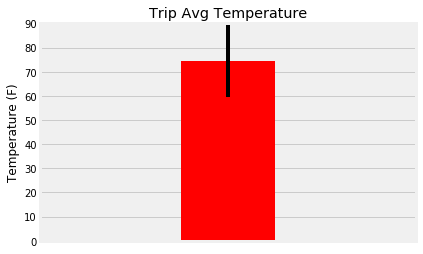

In [27]:
# Ploting the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_axis = 1
y_axis = temp_avg
error = temp_max-temp_min

# Defining Bar and Error paramaters
plt.bar(x_axis, y_axis, yerr=error, align='center', color = "r")
plt.tick_params(bottom=False,labelbottom=False)


# Labeling, tickers and grids
plt.ylabel("Temperature (F)")

plt.title("Trip Avg Temperature")
plt.grid(b=None, which="major", axis="x")
plt.margins(1.5, 1.5)
plt.ylim(0, 90)
plt.savefig("Output/Trip Average Temperature")

#Show the Plot
plt.show();

## Optional Challenge Assignment

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("04-01")

[(60.0, 71.87931034482759, 80.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Seting the start and end date of the trip from historic dates
hst_start_date # defined above 
hst_end_date
# Useing the start and end date to create a range of dates

dates = session.query(Measurement.date).filter(Measurement.date >= hst_start_date).filter(Measurement.date <= hst_end_date).group_by(Measurement.date).all()
#saving trip dates into array 
arr_dates = [x[0] for x in dates]
# Reformating dates to mm-dd format and getting data ion a list

arr_dates_mm_dd= [x[5:] for x in arr_dates]

start_mmdd =  arr_dates_mm_dd[0]
end_mmdd = arr_dates_mm_dd[10]
# Looping through the list of mm-dd and getting max,ave, min temp averages
temps_by_dates = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_mmdd).filter(func.strftime("%m-%d", Measurement.date) <= end_mmdd).group_by(func.strftime("%m-%d", Measurement.date)).all()]

temps_by_dates = temps_by_dates[0]
#displaying averages for each date of the trip

temps_by_dates

[(60.0, 71.87931034482759, 80.0),
 (53.0, 71.82142857142857, 79.0),
 (55.0, 72.2280701754386, 78.0),
 (58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142857, 77.0),
 (63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0)]

In [37]:
# reformating list of temp into Pandas DataFrame
temps_by_dates_df= pd.DataFrame(temps_by_dates,columns=["min_t","avg_t","max_t"])

#Adding date column
temps_by_dates_df["date"]= arr_dates_mm_dd

# Seting index to date
temps_by_dates_df.set_index("date",inplace=True)

temps_by_dates_df

,min_t,avg_t,max_t
date,,,
04-01,60.0,71.879310,80.0
04-02,53.0,71.821429,79.0
04-03,55.0,72.228070,78.0
04-04,58.0,72.016393,78.0
04-05,61.0,72.288136,80.0
04-06,67.0,71.571429,77.0
04-07,63.0,71.105263,78.0
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0


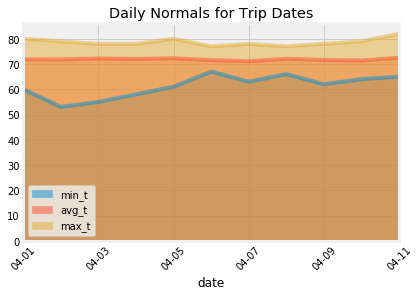

In [38]:
# Ploting the daily normals as an area plot with `stacked=False`
temps_by_dates_df.plot(kind='area', stacked=False, x_compat=True, title="Daily Normals for Trip Dates")
plt.xticks(rotation="45")
plt.savefig(("Output/Temp Frequency"))
plt.show()
